# 2 point correlation function (2PCF)
### This code compute the two point correlation function of series of points embedded into space and store in GeoPandaDataFrame format.
### I- Compute the 2PCF for random point
### II- Compute  the 2PCF for the system of interest
### III- Fit the 2PCF to find the gamma of the Soneira-Peebles model

In [31]:
import sklearn.cluster as sk
import itertools
import sys
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from pathlib import Path
import geopandas as gpd
path = Path().cwd().parent / "src" #to add the src directory to the path regognized by Python
sys.path.append(str(path))
import methods_two_point_correlation as mtpc
import save_load_pickle as slp
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
# Bookkeeping of important path in the project
data_dir = Path().cwd().parent/Path("data")
data_city = data_dir / "cities"
data_map = data_dir / "map"
out_dir = Path().cwd().parent/Path("out")
plot_dir = out_dir / Path("plot")

## Parameters

In [32]:
name = "Switzerland" #name of the system considered
name_random = f"Random{name}"
threshold = 1 # minimal number of inhabitants for the city to be considered
N_run = 5 # number of random catalog geenrated for computing the 2PCF
size = 7000 #number of points each random catalog has
k = 3  #number of time the 2PCF computing process is repeated to estimate variance
rmax = 1e5 #maximal distance between two points considered, if None, taken from data
scale = "lin"
nbins = 20 # number of bins to consider in the computation of 2PCF

In [33]:
##Preprocessing
crs = mtpc.crs_selector(name) # Coordinate reference system of the country considered
path_city = data_city / f"{name}_cities.csv"
path_border = data_map / f"{name}.geojson"
gdf_city = mtpc.load_df_to_gdf(path_city,threshold) # Geopandas of the dataset
gdf_edge = gpd.read_file(path_border) #Geopandas of the polygon border of the dataset
gdf_projected = gdf_city.to_crs(crs) # Projection in the right coordinate system
coord = gdf_projected.get_coordinates() # Coordinates of the points in dataset


In [34]:
crs

'EPSG:21781'

## 2PCF for random point
### Evaluation of the 2PCF requires one or several catalog of random points that fit
### the surface on which the spatial points lies.
### Here we check that the 2PCF of random point is around zero at all scale to ensure there are no biases for the real system at the parameters we consider

In [35]:
##Create directories and path to save data
path_save_random = out_dir/Path("2pcf_random") /Path(f"{name_random}/")
path_save_random.mkdir(parents=True,exist_ok=True)

In [36]:
name_save_random = path_save_random/Path(f"{threshold}_{N_run}_{size}_{k}_{rmax}_{scale}_{nbins}")
gdf_projected_random= mtpc.generate_random_point(gdf_edge,len(gdf_city),crs,check_gpd=True)
r_edges,l_xi = mtpc.PCF_with_variance(gdf_projected_random,gdf_edge,crs,N_run,size,k,rmax,scale,nbins=nbins)
distance_distribution = mtpc.compute_DD(gdf_projected_random)
d_save = {}
d_save["r_edges"] = r_edges
d_save["xi"] = l_xi
d_save["distance_distribution"] = distance_distribution
slp.save_results(name_save_random,d_save)

0
1
2
3
2248.7836852738565 100000.0
1.0
1.0
1.0
0
1
2
3
2248.7836852738565 100000.0
1.0
1.0
1.0
0
1
2
3
2248.7836852738565 100000.0
1.0
1.0
1.0


<Axes: >

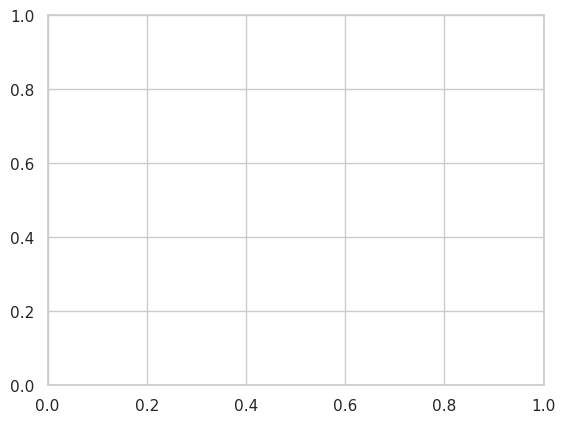

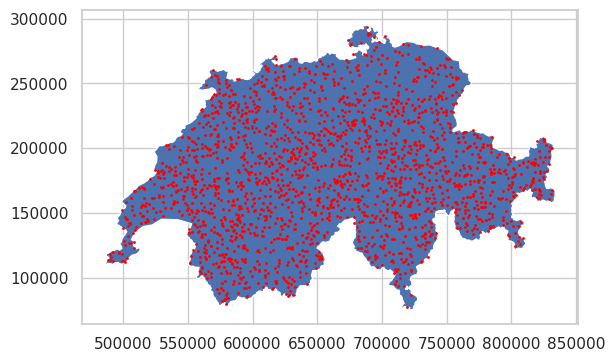

In [37]:
fig, ax = plt.subplots()
ax=gdf_edge.to_crs(crs).plot()
gdf_projected_random.plot(ax=ax,color="red",markersize=1)

In [38]:
def plot_2pcf(load_file):
    i=1
    name = load_file.parent.name
    fig, ax = plt.subplots()
    sns.set(style="whitegrid")
    d = slp.load_results(load_file)
    r_edges, l_xi = d["r_edges"],d["xi"]
    xi = np.mean(l_xi,axis=0)
    error = np.std(l_xi,axis=0)
    if len(xi) != len(r_edges): #when we choose a rmax define by user the code put an extra category above
        xi = xi[0:-1]
        error = error[0:-1]
    color = sns.color_palette("viridis")[0]
    r_edges = r_edges[1:]
    xi = xi[1:]
    error = error[1:]
    end = np.zeros([1])
    end[0] = 1.1*r_edges[-1]
    r_edges_zero = np.concatenate((r_edges,end))
    width = np.diff(r_edges_zero) #need to find a way to encode properly the first alignement
    ax.bar(r_edges,xi,width=width,align="center",edgecolor="black",color=color,alpha=0.5)
    plt.errorbar(r_edges, xi, yerr=error, fmt="o", color="r",ms=1)
    title = "2 points correlation function "+name
    plt.title(title)
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r$ (meters)")
    plt.xscale("log")
    #plt.yscale("log")
    #plt.legend()
    plt.savefig(plot_dir / title, format="png",transparent=True)
    plt.show()

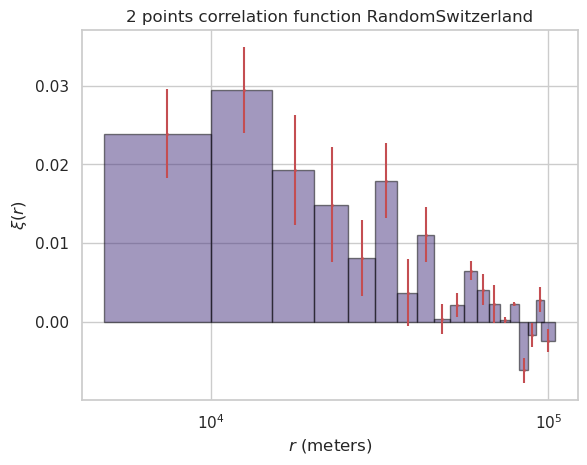

In [39]:
plot_2pcf(name_save_random)

## 2PCF for the dataset

In [40]:
##Create directories and path to save data
path_save = out_dir /Path("2pcf") /Path(f"{name}/")
path_save.mkdir(parents=True,exist_ok=True)

In [47]:
name_save = path_save/Path(f"{threshold}_{N_run}_{size}_{k}__{rmax}_{scale}_{nbins}")
r_edges,l_xi = mtpc.PCF_with_variance(gdf_projected,gdf_edge,crs,N_run,size,k,rmax,scale,nbins=nbins)
distance_distribution = mtpc.compute_DD(gdf_projected)
d_save = {}
d_save["r_edges"] = r_edges
d_save["xi"] = l_xi
d_save["distance_distribution"] = distance_distribution
slp.save_results(name_save,d_save)

0
1
2
3
2001.2286603309706 100000.0
1.0
1.0
1.0
0
1
2
3
2001.2286603309706 100000.0
1.0
1.0
1.0
0
1
2
3
2001.2286603309706 100000.0
1.0
1.0
1.0


<Axes: >

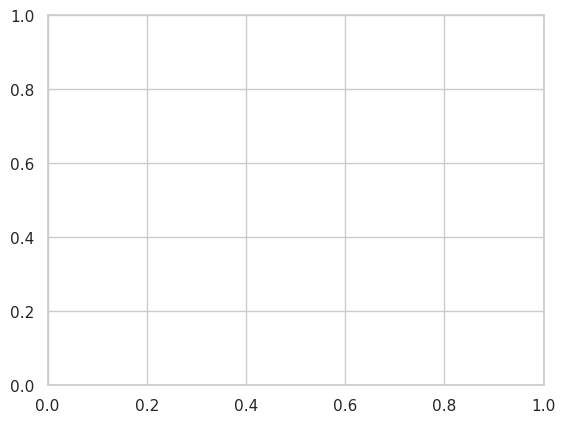

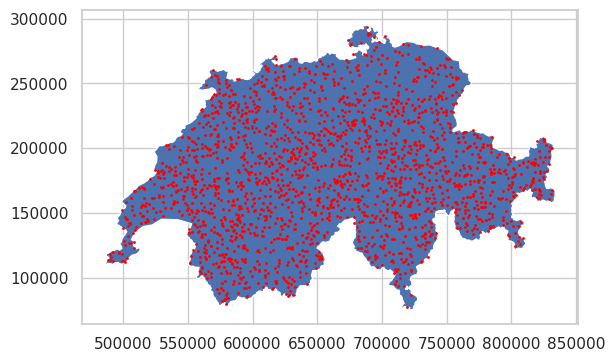

In [48]:
fig, ax = plt.subplots()
ax=gdf_edge.to_crs(crs).plot()
gdf_projected_random.plot(ax=ax,color="red",markersize=1)

In [49]:
distance_distribution[0]

224522

In [50]:
gdf_city.head()

,Unnamed: 0,city,city_ascii,city_alt,lat,lng,country,iso2,iso3,admin_name,admin_name_ascii,admin_code,admin_type,capital,density,population,population_proper,ranking,timezone,same_name,id,geometry
0,1952692,Zürich,Zurich,Turicum|Zurich|Zurigo|Turitg,47.3744,8.5411,Switzerland,CH,CHE,Zürich,Zurich,CH-ZH,canton,admin,5087.4,447082.0,447082.0,2,Europe/Zurich,False,1756539143,POINT (8.5411 47.3744)
1,1952693,Geneva,Geneva,Genf|Genève|Ginevra|Genevra,46.2017,6.1469,Switzerland,CH,CHE,Genève,Geneve,CH-GE,canton,admin,13291.3,203840.0,203840.0,2,Europe/Zurich,False,1756810813,POINT (6.1469 46.2017)
2,1952694,Basel,Basel,Basilia|Robur|Basle|Basilea|Bâle,47.5547,7.5906,Switzerland,CH,CHE,Basel-Stadt,Basel-Stadt,CH-BS,canton,admin,7276.8,173552.0,173552.0,2,Europe/Zurich,False,1756731313,POINT (7.5906 47.5547)
3,1952695,Lausanne,Lausanne,Losanna,46.5198,6.6335,Switzerland,CH,CHE,Vaud,Vaud,CH-VD,canton,admin,3417.5,141418.0,141418.0,2,Europe/Zurich,False,1756055099,POINT (6.6335 46.5198)
4,1952696,Bern,Bern,Berne|Berna|Bern|Berna,46.9481,7.4475,Switzerland,CH,CHE,Bern,Bern,CH-BE,canton,primary,2605.7,134506.0,134506.0,1,Europe/Zurich,False,1756374318,POINT (7.4475 46.9481)


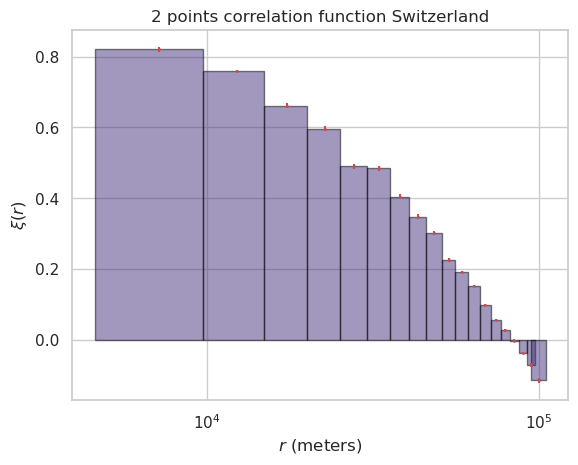

In [51]:
plot_2pcf(name_save)

In [46]:
np.mean(l_xi,axis=0)

array([ 0.51574647,  0.80621697,  0.73898602,  0.64040715,  0.58056012,
        0.47681971,  0.46993581,  0.38980611,  0.33823926,  0.29359204,
        0.22041378,  0.18650529,  0.14885766,  0.09975736,  0.05833955,
        0.02957895,  0.00243418, -0.03426281, -0.07019976, -0.11236773,
       -0.14374536])

In [52]:
np.mean(l_xi,axis=0)

array([ 0.52443097,  0.82102437,  0.75889494,  0.66054906,  0.59633134,
        0.48976773,  0.48384486,  0.40401634,  0.34753968,  0.30132549,
        0.2254386 ,  0.19132044,  0.15105711,  0.09825523,  0.05536202,
        0.02665436, -0.0022777 , -0.03848892, -0.0717256 , -0.11479094,
       -0.14612879])

In [53]:
np.std(l_xi,axis=0)

array([0.00712993, 0.00673114, 0.00355327, 0.00696791, 0.0068214 ,
       0.00656498, 0.00719531, 0.0066084 , 0.00647055, 0.00623546,
       0.00518484, 0.00325199, 0.00311047, 0.00274257, 0.00305568,
       0.00362433, 0.00417136, 0.00278927, 0.00562815, 0.0066136 ,
       0.00386605])

In [54]:
len(gdf_city)

2114

## Fit the 2PCF to find the gamma of the Soneira-Peebles model

In [56]:
def power_law(r, gamma,r0):
     model = (r/r0)**(-gamma)
     return model
a,b = 1,19
xi = np.mean(l_xi,axis=0)
error = np.std(l_xi,axis=0)
xi_reduced = xi[a:b]
r_reduced = r_edges[a:b]
error_reduced = error[a:b]
popt,pcov = curve_fit(power_law,r_reduced,xi_reduced,sigma=error_reduced)

d_save = {}
d_save["r_edges"] = r_edges
d_save["xi"] = l_xi
d_save["distance_distribution"] = distance_distribution
d_save["fit_SP"] = popt
d_save["covariance_fit"] = pcov
slp.save_results(name_save_random,d_save)

In [57]:
def plot_2pcf_with_fit(load_file,popt,pco,scale):
    i=1
    name = load_file.parent.name
    fig, ax = plt.subplots()
    sns.set(style="whitegrid")
    d = slp.load_results(load_file)
    r_edges, l_xi = d["r_edges"],d["xi"]
    xi = np.mean(l_xi,axis=0)
    error = np.std(l_xi,axis=0)
    color = sns.color_palette("viridis")[0]
    r_edges = r_edges#[1:]
    xi = xi#[1:]
    error = error#[1:]
    if len(xi) != len(r_edges): #when we choose a rmax define by user the code put an extra category above
        xi = xi[0:-1]
        error = error[0:-1]
    end = np.zeros([1])
    end[0] = 1.1*r_edges[-1]
    r_edges_zero = np.concatenate((r_edges,end))
    width = np.diff(r_edges_zero) #need to find a way to encode properly the first alignement
    ax.bar(r_edges,xi,width=width,align="center",edgecolor="black",color=color,alpha=0.5)
    plt.errorbar(r_edges, xi, yerr=error, fmt="o", color="r",ms=1)
    delta_gamma,delta_r0=np.sqrt(np.diag(pcov))
    popt1 = [popt[0]+delta_gamma,popt[1]+delta_r0]
    popt2 = [popt[0]-delta_gamma,popt[1]-delta_r0]
    popt3 = [popt[0]+delta_gamma,popt[1]-delta_r0]
    popt4 = [popt[0]-delta_gamma,popt[1]+delta_r0]
    plt.plot(r_edges, power_law(r_edges, *popt), '--',label=f"$\gamma={np.round(popt[0],3)} +- {np.round(delta_gamma,3)},r_0={np.round(popt[1],0)} +- {np.round(delta_r0,0)}$")
    plt.plot(r_edges, power_law(r_edges, *popt1), '--',color="red")
    plt.plot(r_edges, power_law(r_edges, *popt2), '--',color="orange")
    plt.plot(r_edges, power_law(r_edges, *popt3), '--',color="green")
    plt.plot(r_edges, power_law(r_edges, *popt4), '--',color="purple")
    print(popt2)
    title = "Fit 2 points correlation function "+name
    plt.title(title)
    plt.ylabel(r"$\xi(r)$")
    plt.xlabel(r"$r$ (meters)")
    plt.xscale(scale)
    #plt.yscale("log")
    plt.legend()
    plt.savefig( plot_dir / title, format="png",transparent=True)
    plt.show()

In [58]:
np.sqrt(np.diag(pcov))

array([1.21290153e-01, 1.07132249e+03])

[0.7977496602482615, 6969.731741638567]


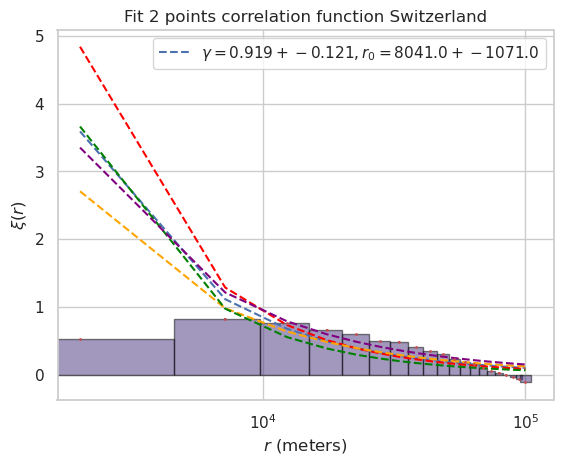

In [59]:
plot_2pcf_with_fit(name_save,popt,pcov,"log")

In [21]:
popt

array([2.04792421e+00, 4.71735519e+03])

In [42]:
np.sqrt(np.diag(pcov))

array([1.22661093e-01, 7.01066089e+02])

In [43]:
popt

array([9.14647730e-01, 2.54862218e+03])

In [44]:
*popt

SyntaxError: can't use starred expression here (184306875.py, line 1)